In [1]:
# Code below is adapted and extended from various sources, including:
# https://colab.research.google.com/github/lucmos/DLAI-s2-2020-tutorials/blob/master/08/8_Variational_Autoencoders_%28VAEs%29.ipynb#scrollTo=7Gl6gEAT8cr4
# https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb
# https://maurocamaraescudero.netlify.app/post/minimalist-variational-autoencoder-in-pytorch-with-cuda-gpu/
# https://maurocamaraescudero.netlify.app/post/assessing-a-variational-autoencoder-on-mnist-using-pytorch/
# https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=_7LAJM9awcLK

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [3]:
# Hyper-parameters

batch_size = 128
num_epochs = 100
x_dim = 784 # image size 28 x 28

h_dim1 = 128
h_dim2 = 64
z_dim = 2

In [4]:
# MNIST

train_dataset = datasets.MNIST(root='./mnist_data/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', 
                              train=False, 
                              transform=transforms.ToTensor(), 
                              download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [5]:
# Model definition

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [6]:
# Train/test definition

vae = VAE(x_dim=x_dim, h_dim1= h_dim1, 
          h_dim2=h_dim2, z_dim=z_dim)
if torch.cuda.is_available():
    vae.cuda()

optimizer = optim.Adam(vae.parameters())
# loss = reconstruction error + KL divergence
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, 
                                 x.view(-1, x_dim), 
                                 reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - 
                           mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch):
    vae.train() # Training mode on
    train_loss = []
    av_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)       
        loss.backward()
        optimizer.step()
        
        av_loss =  loss.item() / len(data) 
        train_loss.append( av_loss )
    return(train_loss)

def test():
    vae.eval() # Test mode on
    test_loss= []
    loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up over batch
            loss += loss_function(recon, data, mu, log_var).item()
    test_loss.append( loss / len(test_loader.dataset)) 
    return(test_loss)

In [7]:
# Train and test

trnLoss, tstLoss = [], []
for epoch in range(num_epochs):
    errs = train(epoch)
    epoch_trnLoss = sum(errs) / len(errs)
    trnLoss.append(epoch_trnLoss)
    
    tstLoss.append(test())
    # print(f"epoch {epoch}")

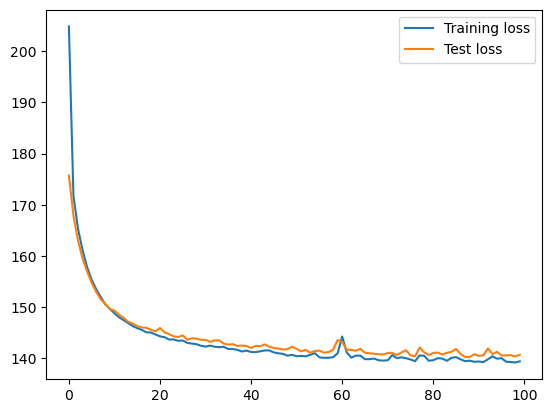

In [8]:
plt.plot(trnLoss, label="Training loss")
plt.plot(tstLoss, label="Test loss")
plt.legend()

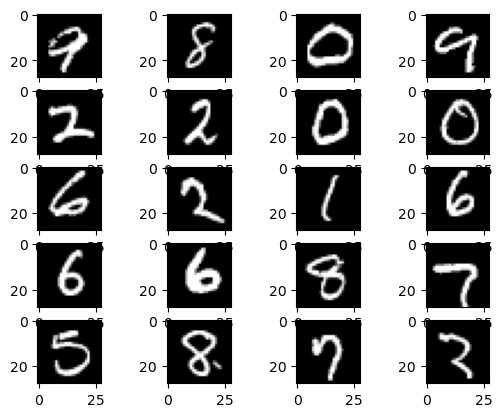

In [9]:
images, labels = next(iter(train_loader))

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(images[i].reshape(28,28), cmap="gray")

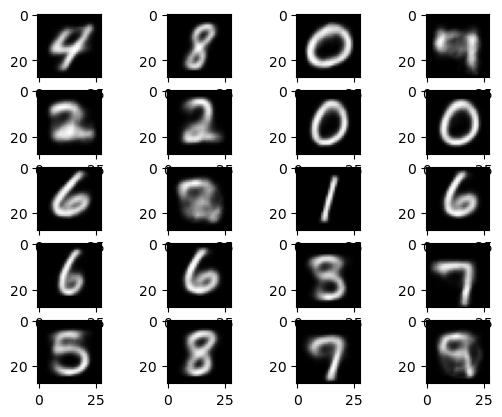

In [10]:
with torch.no_grad():
    images = images.cuda()
    recon, mu, log_var = vae(images)

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(recon[i].cpu().reshape(28,28), cmap="gray")

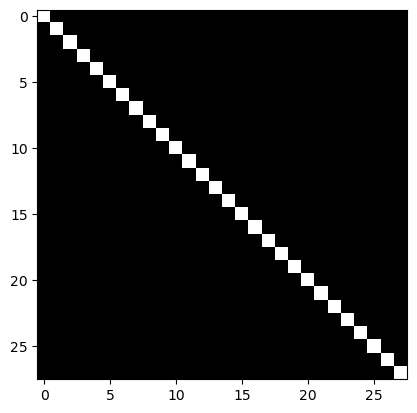

In [11]:
# Trained VAE responds to OOD inputs with 
# a weighted sum of nearest neighbors.

imgs, lbls = next(iter(test_loader))
x = imgs.view(len(imgs), 28,28)

y = x[1] # re-use & reset a test image
for i in range(28):
    y[i, :] = 0.0 # all pixels == 0

# # outer rectangle of 1's:
# y[0, :] = 1.0
# y[-1, :]= 1.0
# y[:, 0] = 1.0
# y[:, -1]= 1.0

# # vertical sides:
# y[:, 0] = 1.0
# y[:, -1]= 1.0

# # horizontal sides:
# y[0, :] = 1.0
# y[-1, :]= 1.0

# # Cross:
# y[13:14, :] = 1.0
# y[:, 13:14] = 1.0

# # 1 vertical:
# y[:, 13:14] = 1.0

# # 1 horizontal:
# y[13:14, :] = 1.0

# diagonal
for i in range(28):
    y[i, i] = 1.0

plt.imshow(y.cpu().numpy(), cmap="gray")

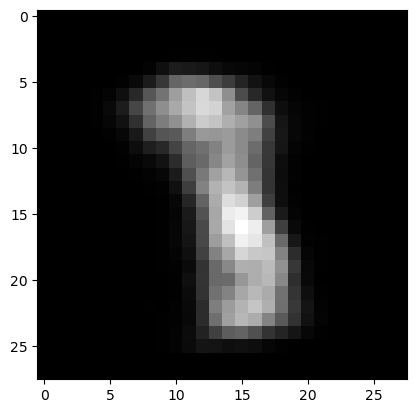

In [12]:
with torch.no_grad():
    out, ltnt_mu, ltnt_logvar = vae(y.cuda())

out_img = out.view(1, 28, 28)
plt.imshow(out_img[0].cpu().numpy(), cmap="gray")

In [13]:
# Generate 'new' latent representations

vae.eval()  # deactivate dropout etc

with torch.no_grad():
    z = torch.randn(500, 2, device='cuda') # 500 z-value pairs

    # make grid of z values
    xVals = [x / 100.0 for x in range(-350, 350, 50)]
    yVals = xVals
    
    N = len(xVals) * len(xVals)
    
    # z = z[:N] #### Optionally plot only images at grid points
    
    sumI = 0
    for i in range(len(xVals)):
        for j in range(len(yVals)):
            zVal =  torch.tensor([xVals[i], yVals[j]]) 
            z[sumI, :] = zVal
            sumI = sumI +1
    
    # Reconstruct images from sampled latent vectors
    rand_z = vae.decoder(z)
    gen_images = rand_z.view(rand_z.size(0), 1, 28, 28)
    gen_images = gen_images.cpu()
    gen_images = gen_images.clamp(0, 1)

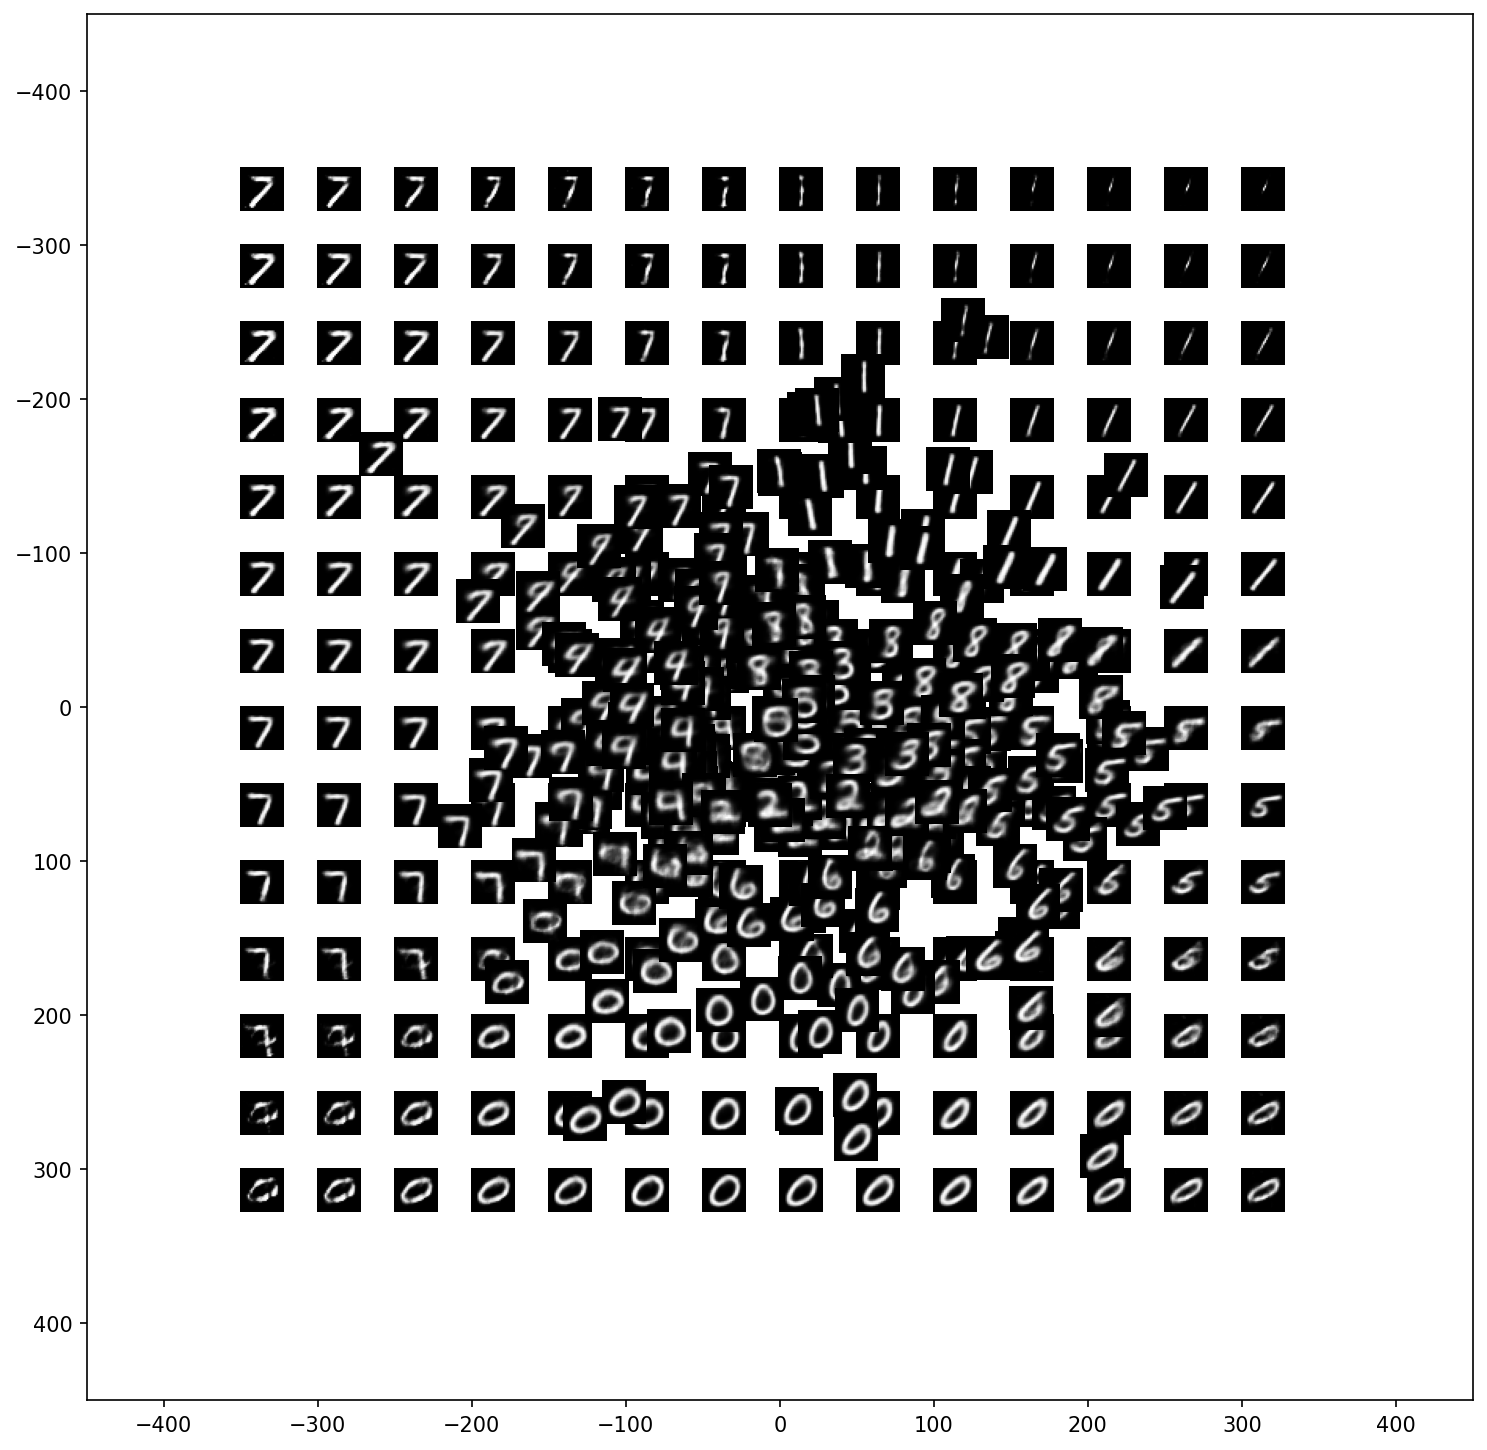

In [14]:
# Plot locations & generated images of sampled points in Z

plt.figure(figsize=(12,12), dpi=150)

coords = z.cpu().numpy() * 100

ims = gen_images.numpy()

ax = plt.gca()
ax.set_xlim(-450, 450)
ax.set_ylim(-450, 450)

for i in range(len(coords)):
    imgplot = ax.imshow(np.transpose(ims[i], (1, 2, 0)), cmap="gray")
    tx, ty = coords[i, :]

    translate = mpl.transforms.Affine2D().translate(tx, ty)
    imgplot.set_transform(translate + ax.transData)

plt.gca().invert_yaxis()

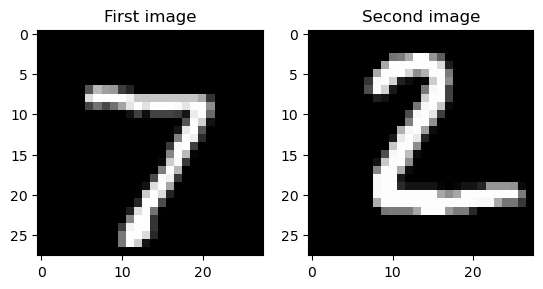

In [15]:
# sort part of test set by digit
digits = [ [] for _ in range(10) ]
for img_batch, label_batch in test_loader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# Pick 2 images to interpolate between
img1 = digits[7][0]
img2 = digits[2][0]

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1.cpu().numpy()[0][0,:,:], cmap="gray")
ax[1].imshow(img2.cpu().numpy()[0][0,:,:], cmap="gray")
ax[0].title.set_text('First image')
ax[1].title.set_text('Second image')

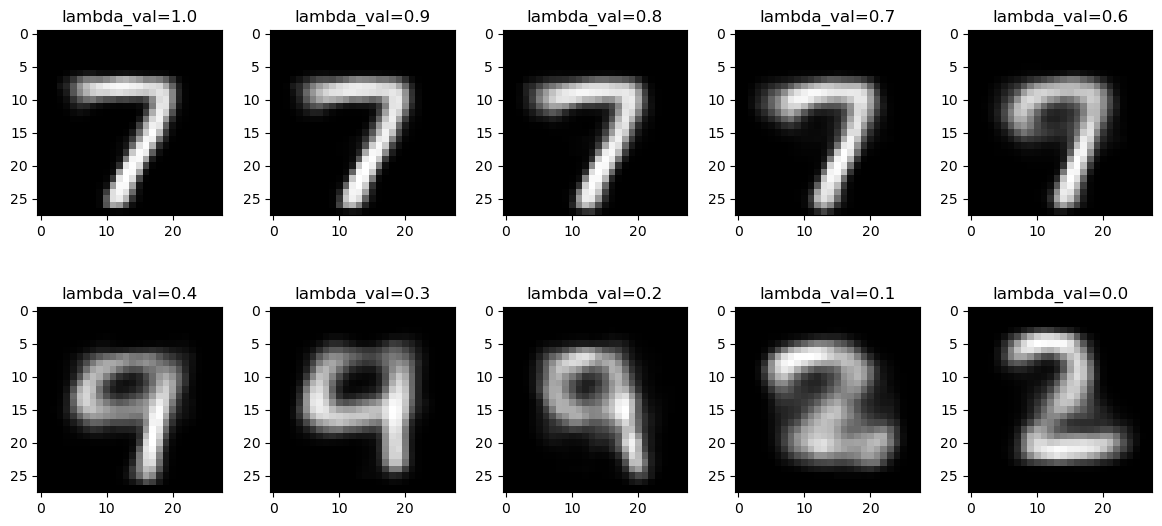

In [16]:
## Interpolate between 2 digits

vae.eval()

# interpolation mixture ratios
lambda_range=np.linspace(1,0,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,L in enumerate(lambda_range):    
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.cuda()
        latent_1, _ = vae.encoder(img1.view(-1, 784))

        # latent vector of second image
        img2 = img2.cuda()
        latent_2, _ = vae.encoder(img2.view(-1, 784))

        # interpolation of the two latent vectors
        inter_latent = float(L) * latent_1 + (1 - float(L)) * latent_2

        # reconstruct interpolated image
        inter_image = vae.decoder(inter_latent)
        inter_image = inter_image.cpu()
        
        inter_image=inter_image.view(inter_image.size(0), 1, 28, 28)
        image = inter_image.numpy()[0]

        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(L,1)))
plt.show() 